# Stock Price Prediction

## Importing the libraries

In [2]:
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.9/316.9 MB 4.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.0-py2.py3-none-any.whl size=317425344 sha256=d1a6ac4347a79f011b9f67949dd17344e3a941a88455b788392743c1286ba8cb
  Stored in directory: /root/.cache/pip/wheels/41/4e/10/c2cf2467f71c678cfc8a6b9ac9241e5e44a01940da8fbb17fc
Successfully built pyspark


In [3]:
!pip install lime
!pip install yahoo_fin

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 5.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=cf1c617861e3d1c4e35a013e0a8ae9b21bcb6cb19a1730b0d40fa3a904c57169
  Stored in directory: /root/.cache/pip/wheels/fd/a2/af/9ac0a1a85a27f314a06b39e1f492bee1547d52549a4606ed89
Successfully built lime
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.1/81.1 kB 6.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.4/83.4 kB 9.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.4/143.4 kB 14.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.8/106.8 kB 11.2 MB/s eta 0:00:00
  Created wheel for bs4: filename=bs4-0.0.1-py3-none-any.whl size=1256 sha256=afa19ff4054ff80612c644d1031373baeedfde21a223725f095fe35e06873c0f
  Stored in directory: /root/.cache/pip/wheels/25/4

In [82]:
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.feature import VectorAssembler
from yahoo_fin import stock_info as si
import datetime as dt
from pyspark.ml import Pipeline
import pandas_datareader as pdr
from pyspark.ml.regression import GBTRegressor
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession
from pyspark.sql.functions import year, month, dayofmonth, concat, lpad, monotonically_increasing_id
from pyspark.ml.regression import RandomForestRegressor
from lime.lime_tabular import LimeTabularExplainer
import numpy as np
import pandas as pd
import tensorflow as tf
tfk = tf.keras
tfkl = tf.keras.layers
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

## Data Collection

In [5]:
ticker = 'TSLA'
start_date = dt.datetime(2013, 9, 30)
end_date = dt.datetime.now()
fred_symbols = ['SP500', 'DJIA', 'NASDAQCOM', 'VIXCLS', 'GVZCLS', 'DTWEXBGS', 'IUDSOIA', 'BAMLHE00EHYIEY', 'DFF', 'T10Y2Y', 'DGS10', 'T10YIE', 'T5YIE', 'DTB3']
historical_data = si.get_data(ticker, start_date, end_date, interval='1d')
fred_df = pdr.get_data_fred(fred_symbols, start_date, end_date)

# Data Pre-Processing with Spark

In [6]:
# Initialize SparkSession
spark = SparkSession.builder \
    .appName("StockPrediction") \
    .config("spark.sql.debug.maxToStringFields", "100") \
    .config("spark.driver.maxResultSize", "512m") \
    .config("spark.executor.memory", "512m") \
    .config("spark.driver.memory", "512m") \
    .getOrCreate()

In [7]:
historical_data_spark = spark.createDataFrame(historical_data.reset_index())
fred_df_spark = spark.createDataFrame(fred_df.reset_index())
historical_data_spark = historical_data_spark.withColumnRenamed("index", "DATE")
historical_data_spark = historical_data_spark.drop('ticker', 'adjclose')

historical_data_spark = historical_data_spark.withColumn("year", year("DATE"))
historical_data_spark = historical_data_spark.withColumn("month", month("DATE"))
historical_data_spark = historical_data_spark.withColumn("day", dayofmonth("DATE"))
historical_data_spark = historical_data_spark.withColumn('fulldate', concat(historical_data_spark['year'],
                                                                            lpad(historical_data_spark['month'], 2,
                                                                                 '0'),
                                                                            lpad(historical_data_spark['day'], 2, '0')))
historical_data_spark = historical_data_spark.withColumn('fulldate', historical_data_spark['fulldate'].cast('int'))
fred_df_spark = fred_df_spark.withColumn("Index", monotonically_increasing_id())
dataset_spark = historical_data_spark.join(fred_df_spark, on="DATE", how="left")
dataset_spark = dataset_spark.orderBy("DATE")
dataset_spark = dataset_spark.withColumn("Index", monotonically_increasing_id())
dataset_spark = dataset_spark.dropna()

# Save into an array the DATE column
dates = dataset_spark.select("DATE").collect()
# Dates to convert into pandas array
dates = [date[0] for date in dates]
dataset_spark_training = dataset_spark.drop("DATE")
# Save into an array the close column
all_closes = dataset_spark.select("close").collect()

## Data Explaration

+-----------------+-----------------+-----------------+------------------+
|        min_close|        max_close|       mean_close|      stddev_close|
+-----------------+-----------------+-----------------+------------------+
|8.033332824707031|409.9700012207031|88.14859186700419|106.33179010232465|
+-----------------+-----------------+-----------------+------------------+



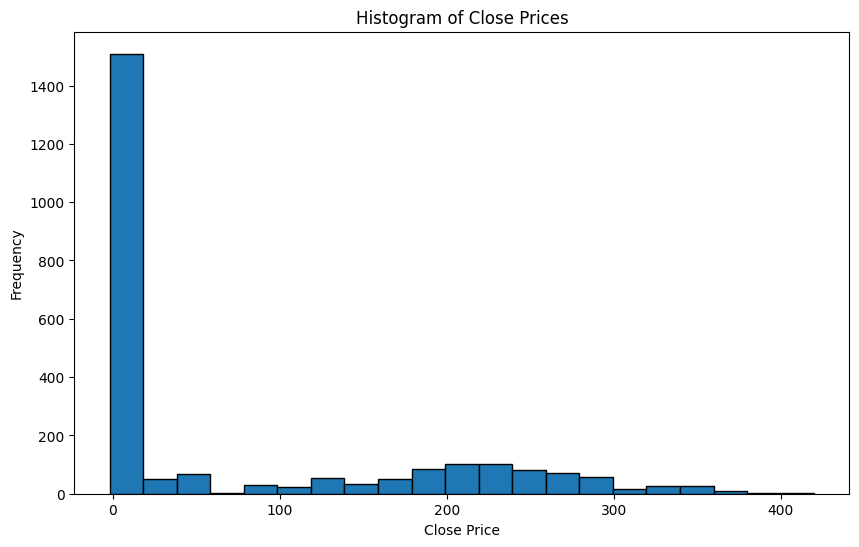

In [8]:
# Use Spark SQL to get some basic statistics and print the results
dataset_spark.createOrReplaceTempView("dataset_spark")

# Calculate summary statistics for the "close" column
summary_query = "SELECT MIN(close) AS min_close, MAX(close) AS max_close, AVG(close) AS mean_close, STDDEV(close) AS stddev_close FROM dataset_spark"
summary_result = spark.sql(summary_query)
summary_result.show()

# Define the number of bins for the histogram
num_bins = 20

# Calculate bin width
bin_width = (summary_result.collect()[0]["max_close"] - summary_result.collect()[0]["min_close"]) / num_bins

# Generate the histogram data
histogram_query = f"SELECT CAST((close - {summary_result.collect()[0]['min_close']}) / {bin_width} AS INT) AS bin, COUNT(*) AS frequency FROM dataset_spark GROUP BY bin ORDER BY bin"
histogram_data = spark.sql(histogram_query)

# Collect the histogram data to the driver
histogram_data_df = histogram_data.toPandas()

# Plot the histogram using Matplotlib
plt.figure(figsize=(10, 6))
plt.bar(histogram_data_df["bin"] * bin_width + summary_result.collect()[0]["min_close"], histogram_data_df["frequency"], width=bin_width, edgecolor='k')
plt.xlabel("Close Price")
plt.ylabel("Frequency")
plt.title("Histogram of Close Prices")
plt.show()

# MLLib

In [9]:
# Prepare data for MLlib
feature_columns = [col_name for col_name in dataset_spark_training.columns if col_name != 'close']
vector_assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
# Determine the split point based on the desired ratio
split_ratio = 0.8  # 80% for training, 20% for testing
split_point = int(dataset_spark_training.count() * split_ratio)

# Split the data into training and testing sets
train_data = dataset_spark_training.limit(split_point)
test_data = dataset_spark_training.subtract(train_data)

# Reorder by index
train_data = train_data.orderBy("Index")
test_data = test_data.orderBy("Index")

## Linear Regression

In [10]:
lr = LinearRegression(labelCol='close', featuresCol='features')
lr_pipeline = Pipeline(stages=[vector_assembler, lr])
# Linear Regression in Spark
lr_model = lr_pipeline.fit(train_data)
# Model Evaluation in Spark
lr_predictions = lr_model.transform(test_data)
evaluator = RegressionEvaluator(labelCol="close", predictionCol="prediction", metricName="rmse")
lr_rmse = evaluator.evaluate(lr_predictions)

# Convert lr_predictions DataFrame to Pandas DataFrame
lr_predictions_pd = lr_predictions.select("Index", "close", "prediction").toPandas()

# Extract the actual "close" values and timestamp
actual_close = lr_predictions_pd["close"]

# Extract the predicted values
lr_predicted_close = lr_predictions_pd["prediction"]

# Take just last 20% of dates (the testing set)
dates_test = dates[split_point:]

## Random Forest

In [11]:
# Create a Random Forest Regressor model
rf = RandomForestRegressor(labelCol='close', featuresCol='features', numTrees=3)
rf_pipeline = Pipeline(stages=[vector_assembler, rf])
# Fit the Random Forest Regressor model
rf_model = rf_pipeline.fit(train_data)
# Model Evaluation in Spark
# Make predictions using the Random Forest Regressor model
rf_predictions = rf_model.transform(test_data)
# Evaluate the Random Forest Regressor model
evaluator = RegressionEvaluator(labelCol="close", predictionCol="prediction", metricName="rmse")
rf_rmse = evaluator.evaluate(rf_predictions)

rf_predictions_pd = rf_predictions.select("Index", "close", "prediction").toPandas()
# Extract the predicted values
rf_predicted_close = rf_predictions_pd["prediction"]

## Gradient Boosted Tree

In [12]:
# Create a Random Forest Regressor model
gbt = GBTRegressor(labelCol='close', featuresCol='features')
gbt_pipeline = Pipeline(stages=[vector_assembler, gbt])
# Fit the Random Forest Regressor model
gbt_model = gbt_pipeline.fit(train_data)
# Model Evaluation in Spark
# Make predictions using the Random Forest Regressor model
gbt_predictions = gbt_model.transform(test_data)
# Evaluate the Random Forest Regressor model
evaluator = RegressionEvaluator(labelCol="close", predictionCol="prediction", metricName="rmse")
gbt_rmse = evaluator.evaluate(gbt_predictions)

gbt_predictions_pd = gbt_predictions.select("Index", "close", "prediction").toPandas()
# Extract the predicted values
gbt_predicted_close = gbt_predictions_pd["prediction"]

# Plot the results

Linear Regression RMSE: 3.812
Random Forest RMSE: 80.703
Gradient Boosted Tree RMSE: 49.945
LSTM RMSE: 49.945


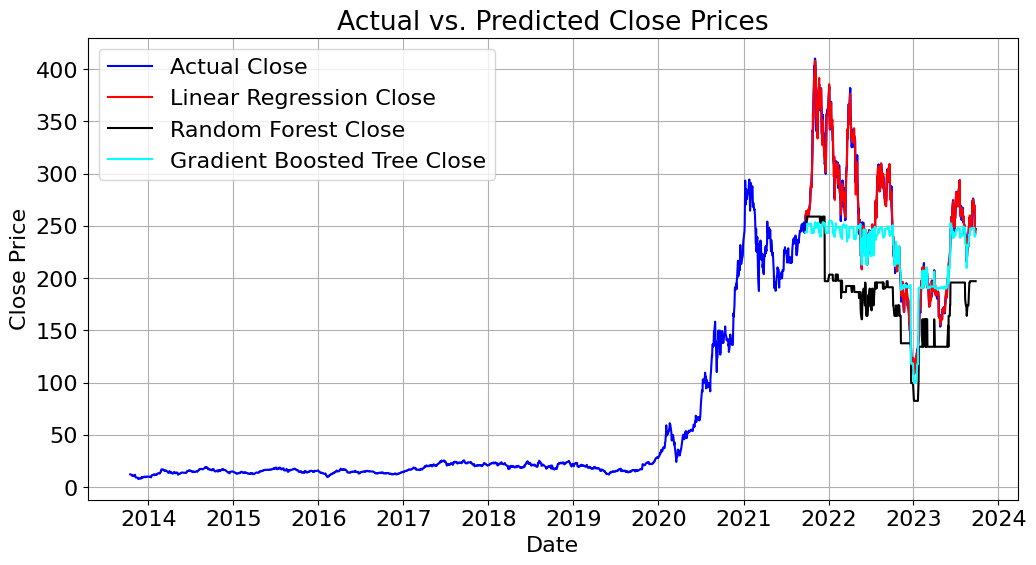

In [88]:
# Print the RMSE for each model
print("Linear Regression RMSE: %.3f" % lr_rmse)
print("Random Forest RMSE: %.3f" % rf_rmse)
print("Gradient Boosted Tree RMSE: %.3f" % gbt_rmse)


# Create a time series plot also with all training data
plt.figure(figsize=(12, 6))
plt.plot(dates, all_closes, color="b")
plt.plot(dates_test, actual_close, label="Actual Close", color="b")
plt.plot(dates_test, lr_predicted_close, label="Linear Regression Close", color="r")
plt.plot(dates_test, rf_predicted_close, label="Random Forest Close", color="k")
plt.plot(dates_test, gbt_predicted_close, label="Gradient Boosted Tree Close", color="aqua")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.title("Actual vs. Predicted Close Prices")
plt.legend()
plt.grid(True)
plt.show()

## LSTM

In [105]:
#Define window sequences
window = 400
stride = 25

def build_sequences(df, window=200, stride=20, telescope=1):
    # Sanity check to avoid runtime errors
    assert window % stride == 0
    dataset = []
    labels = []
    temp_df = df.copy()
    temp_label = df.copy()
    padding_len = len(df)%window

    if(padding_len != 0):
        # Compute padding length
        padding_len = window - len(df)%window
        padding = np.zeros((padding_len,temp_df.shape[1]), dtype='float64')
        temp_df = np.concatenate((padding,df))
        padding = np.zeros((padding_len,temp_label.shape[1]), dtype='float64')
        temp_label = np.concatenate((padding,temp_label))
        assert len(temp_df) % window == 0

    for idx in np.arange(0,len(temp_df)-window-telescope,stride):
        dataset.append(temp_df[idx:idx+window])
        labels.append(temp_label[idx+window:idx+window+telescope])

    dataset = np.array(dataset)
    labels = np.array(labels)
    return dataset, labels

X_train_raw = train_data.toPandas()
X_test_raw = train_data.toPandas()

#Build sequences
telescope = 20
scaler = StandardScaler()
X_train_raw = scaler.fit_transform(X_train_raw)
X_test_raw = scaler.transform(X_test_raw)


(64, 400, 24)


In [ ]:
# Normalize both features and labels
min_Scaler = MinMaxScaler()
X_train_raw = min_Scaler.fit_transform(X_train_raw)
X_test_raw = min_Scaler.transform(X_test_raw)
X_train, y_train = build_sequences(X_train_raw, window, stride, telescope)
X_test, y_test = build_sequences(X_test_raw, window, stride, telescope)
print(X_train.shape)

input_shape = (window, len(feature_columns)+1)
output_shape = (telescope, len(feature_columns)+1)

batch_size = 128
epochs = 100

In [ ]:
#Build model

import tensorflow as tf
from tensorflow.keras import layers


def build_LSTM_model(input_shape, output_shape):
    model = tf.keras.Sequential([
        layers.LSTM(64, input_shape=input_shape),
        layers.RepeatVector(output_shape[0]),
        layers.LSTM(64, return_sequences=True),
        layers.TimeDistributed(layers.Dense(output_shape[1], activation='relu'))
    ])

    loss = tf.keras.losses.MeanSquaredError()
    optimizer = tf.keras.optimizers.Adam()
    model.compile(loss=loss, optimizer=optimizer, metrics=['mse'])

    return model

In [106]:
model = build_LSTM_model(input_shape, output_shape)
model.summary()
#Fit model
loss = model.fit(
    x = X_train,
    y = y_train,
    batch_size = batch_size,
    epochs = epochs,
    validation_split=.1,
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=10, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=5, factor=0.5, min_lr=1e-5)
    ]
)

model.save('model_cnn_lstm_dropout_400_25_20')

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_27 (LSTM)              (None, 64)                22784     
                                                                 
 repeat_vector_4 (RepeatVec  (None, 20, 64)            0         
 tor)                                                            
                                                                 
 lstm_28 (LSTM)              (None, 20, 64)            33024     
                                                                 
 time_distributed_6 (TimeDi  (None, 20, 24)            1560      
 stributed)                                                      
                                                                 
Total params: 57368 (224.09 KB)
Trainable params: 57368 (224.09 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/100
1/1 

In [107]:
predicted = model.predict(X_test)
predicted.shape

2/2 [==============================] - 1s 64ms/step


(64, 20, 24)

In [108]:
combined_array = np.concatenate((y_test, predicted), axis = 1)
print(combined_array[:,0,0].shape)

(64,)


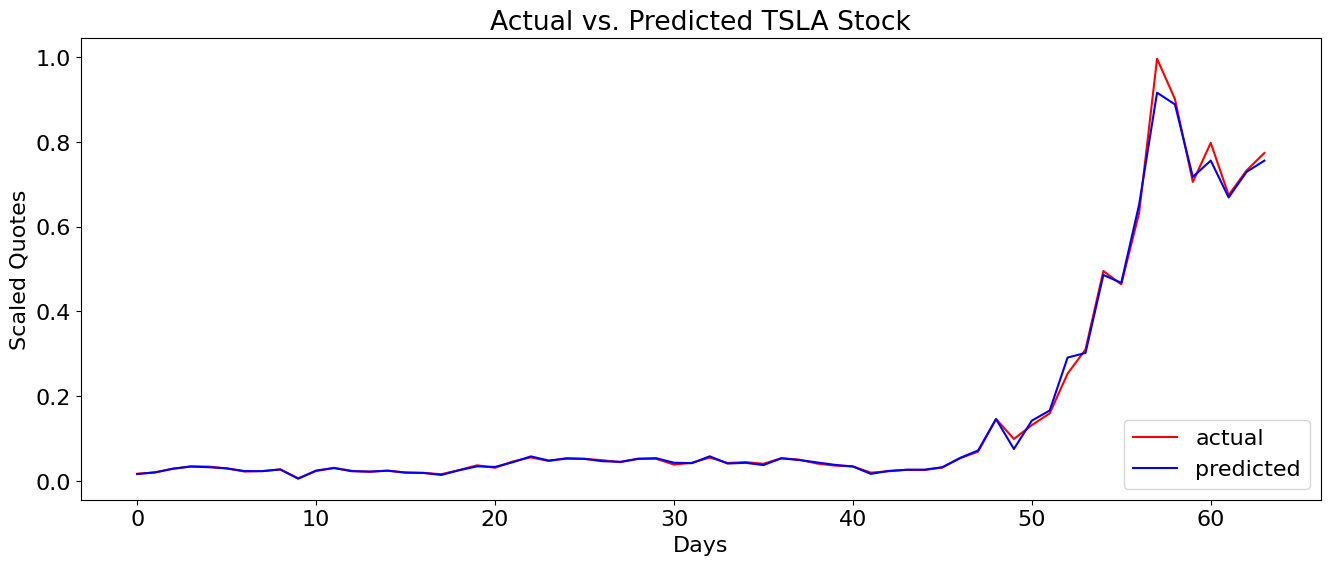

In [109]:
plt.figure(figsize=(16,6))
plt.plot(combined_array[:,0,3],color='red', label='actual')
plt.plot(combined_array[:,1,3],color='blue', label='predicted')
plt.legend(loc = 'lower right')
plt.title('Actual vs. Predicted Stock')
plt.xlabel('Days')
plt.ylabel('Scaled Quotes')
plt.show()


# Explaining the results

## Feature Importance


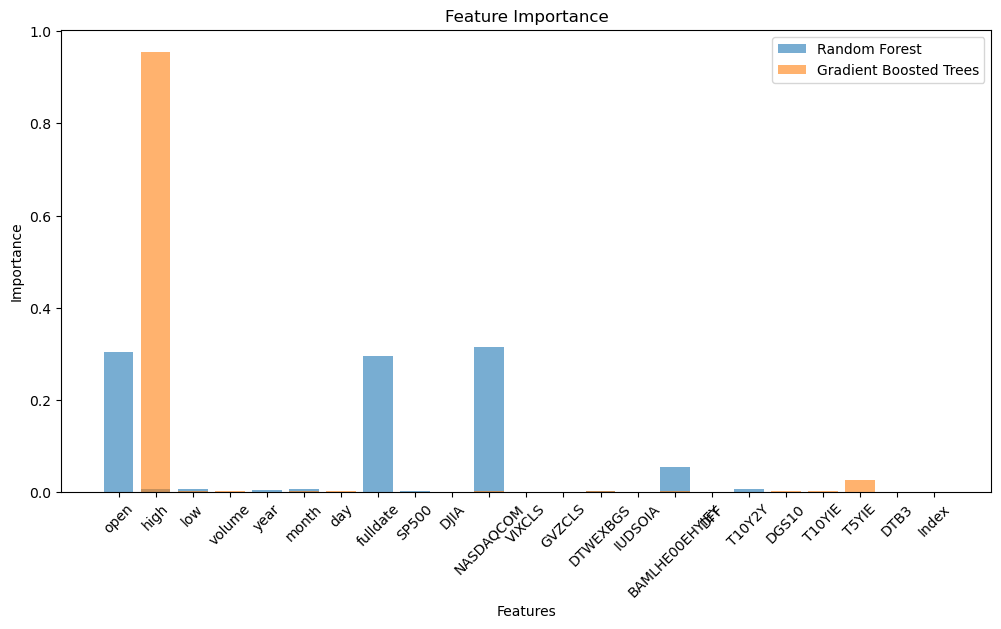

In [ ]:
# For Random Forest
rf_importance = rf_model.stages[-1].featureImportances.toArray()

# For Gradient Boosted Trees
gbt_importance = gbt_model.stages[-1].featureImportances.toArray()

# Plotting feature importance
plt.figure(figsize=(12, 6))
plt.bar(feature_columns, rf_importance, label="Random Forest", alpha=0.6)
plt.bar(feature_columns, gbt_importance, label="Gradient Boosted Trees", alpha=0.6)
plt.xlabel("Features")
plt.ylabel("Importance")
plt.title("Feature Importance")
plt.legend()
plt.xticks(rotation=45)
plt.show()

## XAI - Lime

In [ ]:
train_data_pd = train_data.toPandas()
X_train = train_data_pd.drop(['close'], axis=1)
y_train = train_data_pd[['close']]
test_data_pd = test_data.toPandas()
X_test = test_data_pd.drop(['close'], axis=1)
y_test = test_data_pd[['close']]

In [ ]:
explainer = LimeTabularExplainer(X_train.values,
                                 mode="regression",
                                 feature_names=X_train.columns.tolist(),
                                 training_labels=y_train,
                                 verbose=True)

In [ ]:
instance = X_test.iloc[0].values

In [ ]:
# For the Linear Regression model
print("Explanation for Linear Regression")
lr_prediction_func = lambda x: lr_model.transform(spark.createDataFrame(pd.DataFrame(x, columns=X_test.columns))).select("prediction").toPandas().values
lr_exp = explainer.explain_instance(instance, lr_prediction_func)
lr_exp.show_in_notebook()

Explanation for Linear Regression
Intercept 17.787514702414434
Prediction_local [151.83607453]
Right: 256.8060745930343


In [ ]:
# For the Random Forest model
print("Explanation for Random Forest")
rf_prediction_func = lambda x: rf_model.transform(spark.createDataFrame(pd.DataFrame(x, columns=X_test.columns))).select("prediction").toPandas().values
rf_exp = explainer.explain_instance(instance, rf_prediction_func)
rf_exp.show_in_notebook()


Explanation for Random Forest
Intercept 14.91482541164288
Prediction_local [154.0394174]
Right: 249.43641270963076


In [ ]:
# For the Gradient Boosted Tree model
print("Explanation for Gradient Boosted Tree")
gbt_prediction_func = lambda x: gbt_model.transform(spark.createDataFrame(pd.DataFrame(x, columns=X_test.columns))).select("prediction").toPandas().values
gbt_exp = explainer.explain_instance(instance, gbt_prediction_func)
gbt_exp.show_in_notebook()

Explanation for Gradient Boosted Tree
Intercept 14.148833622928102
Prediction_local [150.84301969]
Right: 243.52636636959252
